# Librerías utilizadas

In [5]:
import networkx as nx
import community as community_louvain
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import linregress
from collections import Counter

# **Formateo de red**

A continuación se muestra una función que tuvimos que utilizar para formatear el archivo **.net**, dado que, el formato original etiquetaba todos los nodos con el mismo nombre "**null**", sobreescribiendo las aristas definidas posteriormente y finalmente dandonos como resultado que
había un solo nodo. Trabajandolo de esta forma, recreamos el mismo grafo pero nombrando cada nodo con un número (siendo este único), así solucionando todo problema.

In [6]:
archivo = "19.net"
with open(archivo, "r", encoding="utf-8") as f:
    lineas = f.readlines()

lineas_vertices = []
lineas_aristas = []
leer_vertices = False # Banderas para ver en que
leer_aristas = False  # parte del archivo estamos

for linea in lineas:
    linea = linea.strip()
    if linea.lower().startswith("*vertices"):
        leer_vertices = True
        leer_aristas = False
        continue
    if linea.lower().startswith("*edges"):
        leer_aristas = True
        leer_vertices = False
        continue

    if leer_vertices:
        lineas_vertices.append(linea)
    elif leer_aristas:
        lineas_aristas.append(linea)

G = nx.Graph() # Nuevo grafo vacío a utilizar

for vline in lineas_vertices:
  parts = vline.split()
  if parts:
      vid = parts[0]
      G.add_node(vid) # Se agregan nodos identificados por números

for eline in lineas_aristas:
  parts = eline.split()
  if len(parts) >= 3:
    source = parts[0]
    target = parts[1]
    weight = float(parts[2])
    G.add_edge(source, target, weight=weight)


FileNotFoundError: [Errno 2] No such file or directory: '19.net'

#**Datos Básicos**

In [ ]:
cant_nodos = G.number_of_nodes()
cant_arcos = G.number_of_edges()
etiqueta = any("label" in G.nodes[n] for n in G.nodes)
pesos = any("weight" in data for _, _, data in G.edges(data=True))

print(" Cantidad de nodos:",cant_nodos,"\n",
      "Cantidad de arcos:", cant_arcos, "\n",
      "Existen etiquetas asociadas a los nodos? :", etiqueta, "\n",
      "Las aristas tienen pesos asociados? :", pesos)

 Cantidad de nodos: 291 
 Cantidad de arcos: 3182 
 Existen etiquetas asociadas a los nodos? : False 
 Las aristas tienen pesos asociados? : True


#**Visualización de la red**

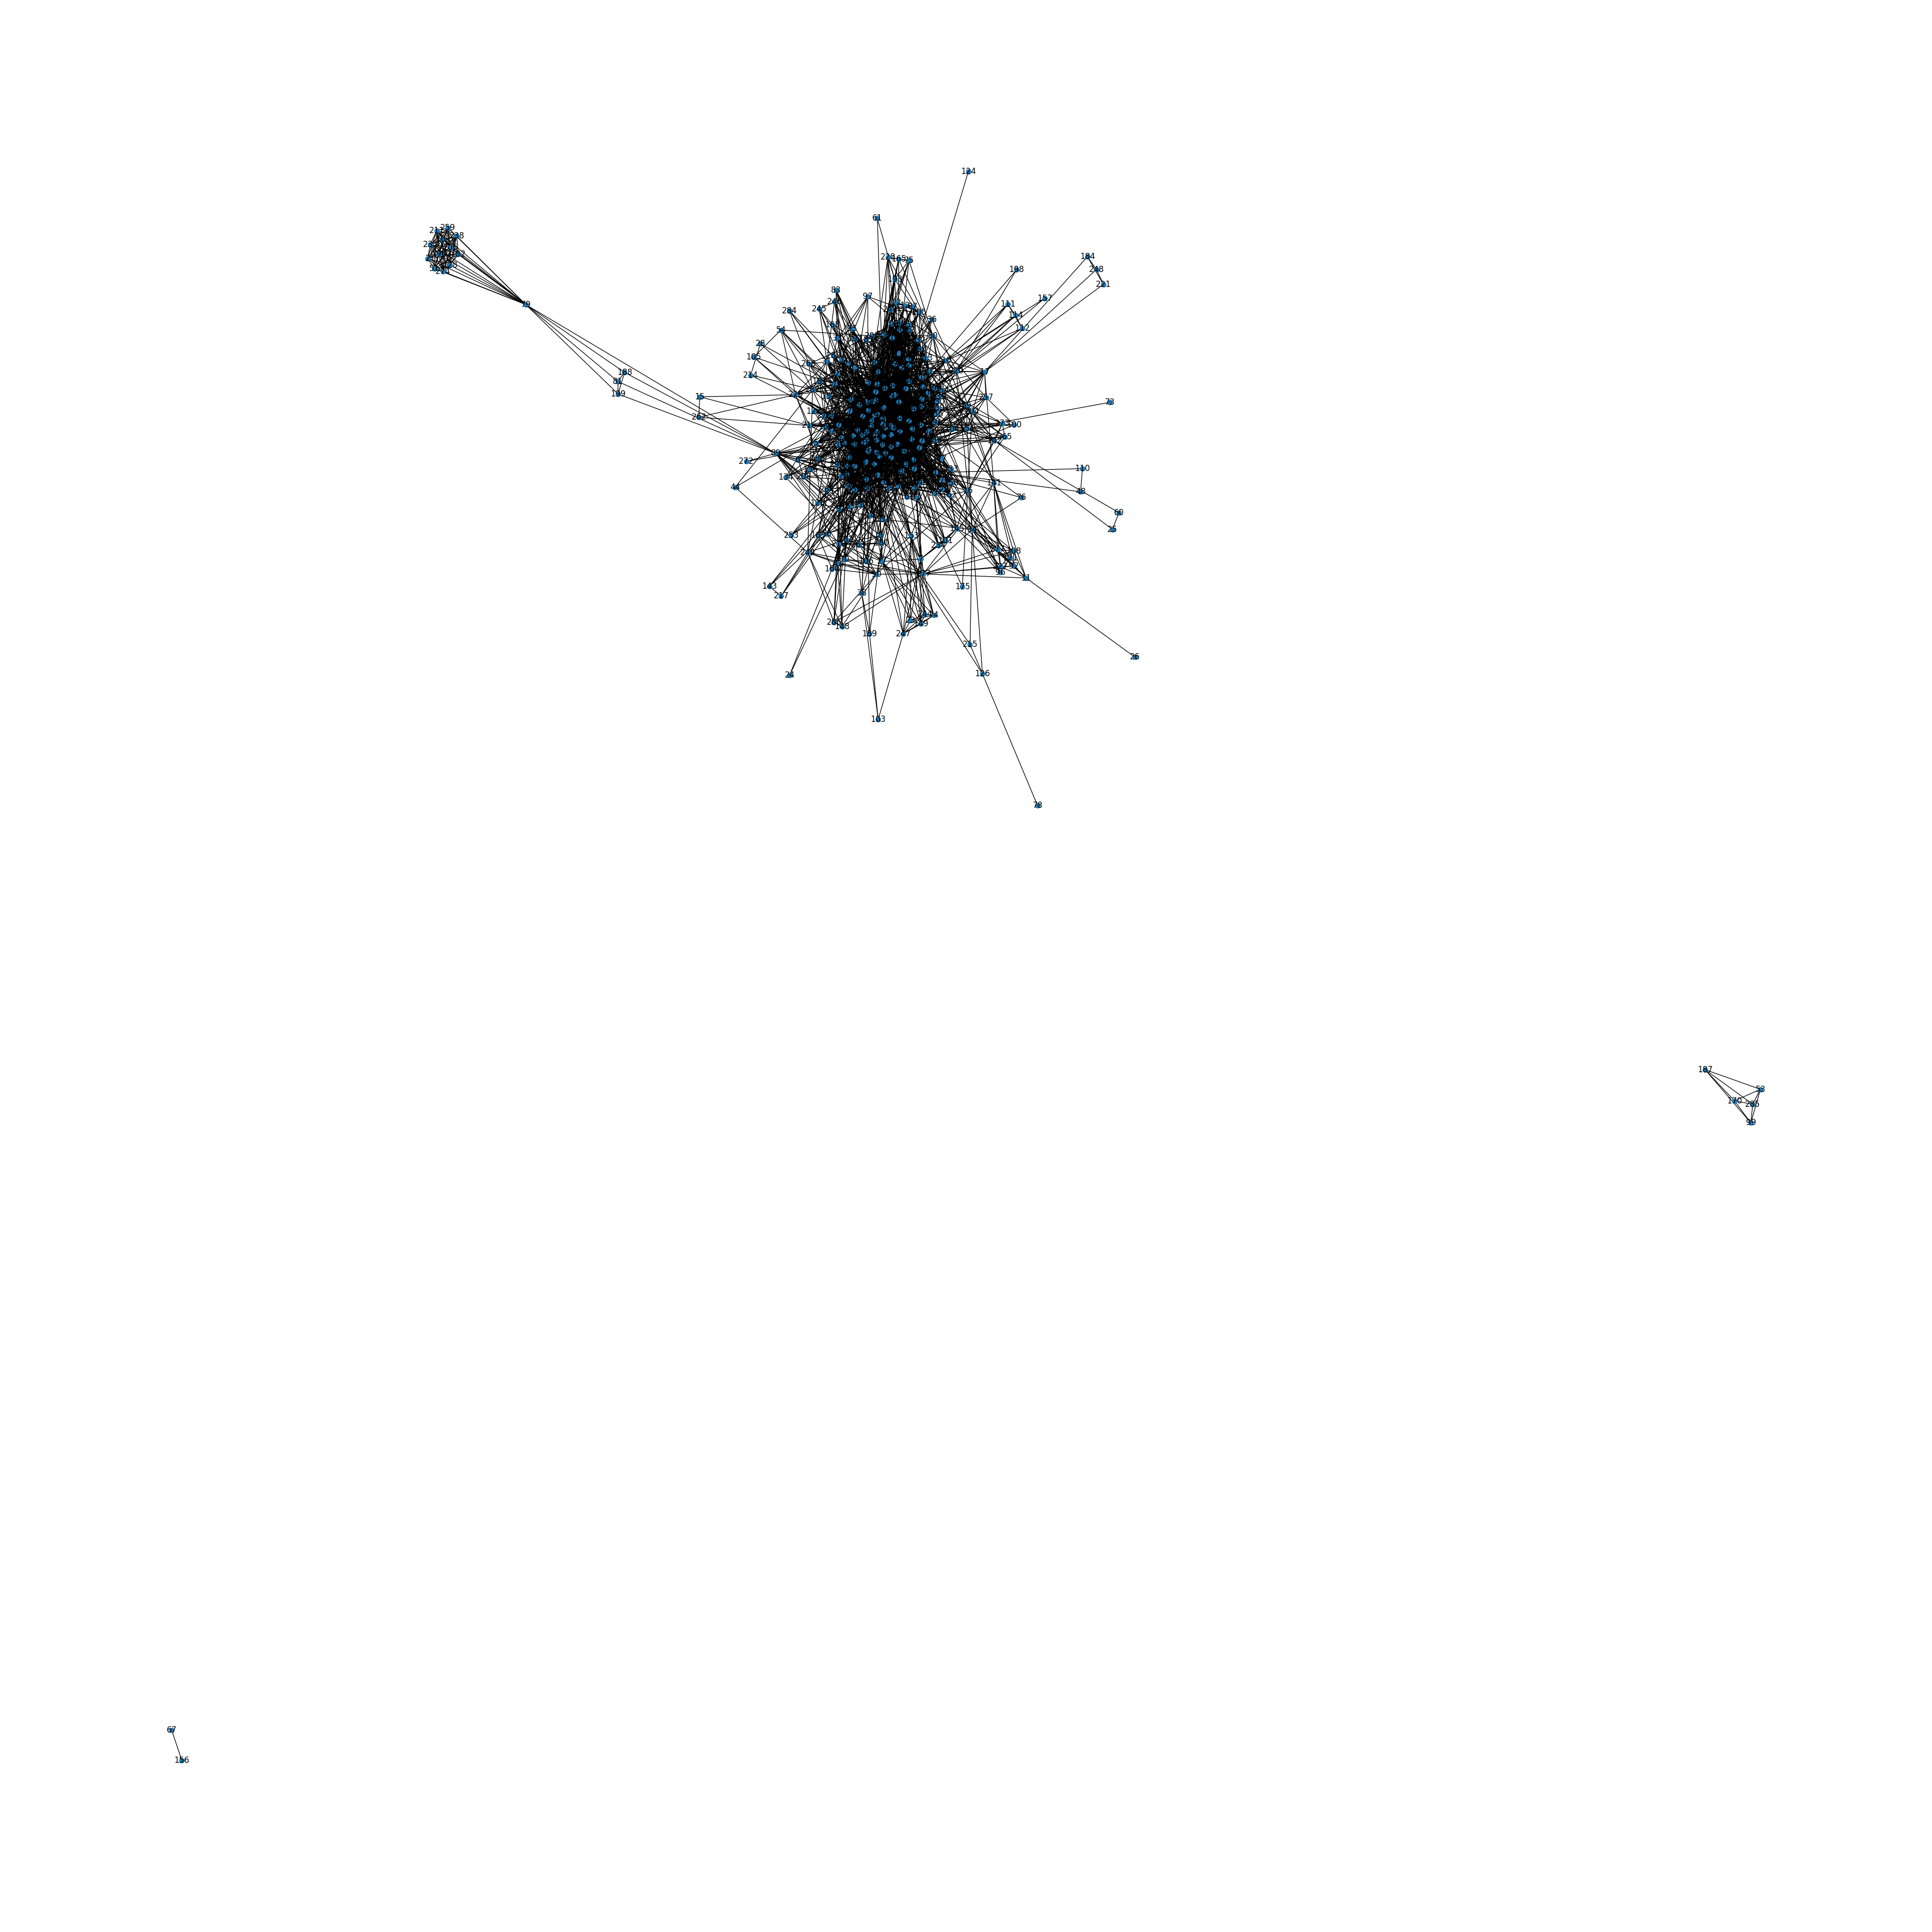

In [ ]:
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(40, 40))
nx.draw(G, pos, with_labels=True, node_size=50)
plt.show()

#**Conexidad**

In [ ]:
componentes = list(nx.connected_components(G))
print("Cantidad de componentes conexas en la red:", len(componentes))

nodos_totales = G.number_of_nodes()
componente_gigante = max(componentes, key=len)
frac_gigante = len(componente_gigante) / nodos_totales
frac_pequeñas = (nodos_totales - len(componente_gigante)) / nodos_totales

print(f"Fracción de nodos en la componente gigante: {frac_gigante:.3f}")
print(f"Fracción de nodos en las componentes pequeñas: {frac_pequeñas:.3f}")

G_gigante = G.subgraph(componente_gigante).copy() # Se extrae el subgrafo de la comp. gigante para trabajar con el

Cantidad de componentes conexas en la red: 3
Fracción de nodos en la componente gigante: 0.976
Fracción de nodos en las componentes pequeñas: 0.024


# **Grados**

## Grado mínimo, máximo, promedio:

In [ ]:
grados = [d for n, d in G_gigante.degree()]
grado_min = min(grados)
grado_max = max(grados)
grado_promedio = sum(grados) / len(grados)

print("Grado mínimo:", grado_min)
print("Grado máximo:", grado_max)
print("Grado promedio:", grado_promedio)

Grado mínimo: 1
Grado máximo: 99
Grado promedio: 22.330985915492956


## Gráfico de distribución de grados:

*Aprovechando que ya tenemos la lista de grados directamente extraída, utilizaremos la sub-biblioteca **matplotlib.pyplot** para graficar.*

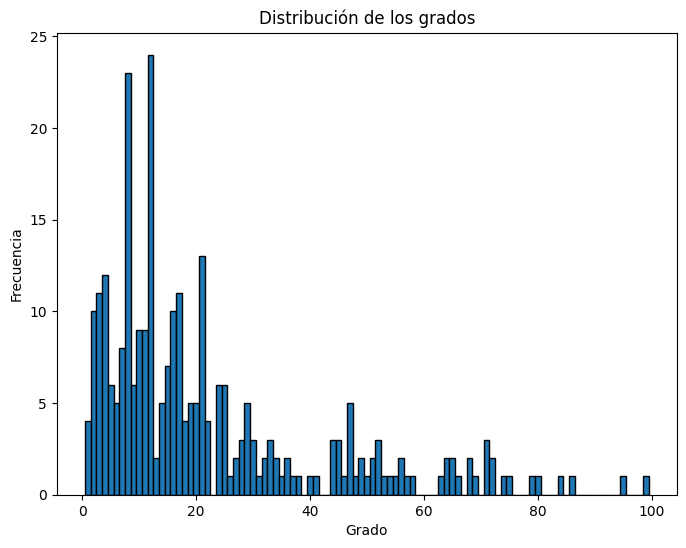

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(grados, bins=range(grado_min, grado_max+2), edgecolor='black', align="left")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")
plt.title("Distribución de los grados")
plt.show()


## Gráfico log-log de dispersión con ajuste (para analizar posible ley de potencia)

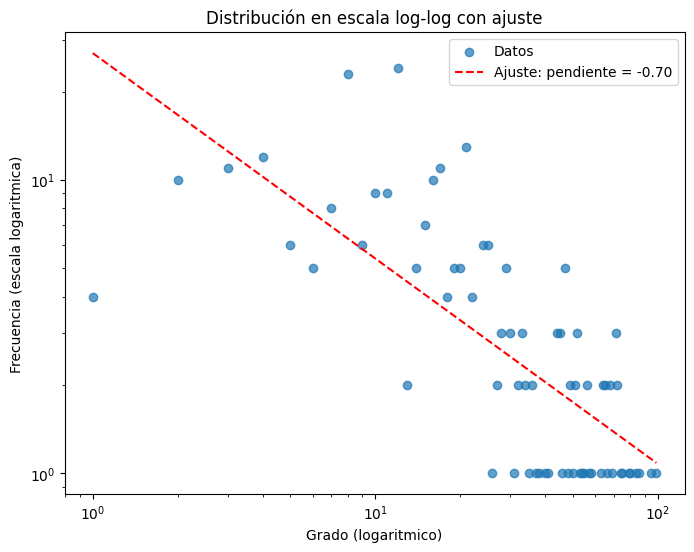

In [ ]:
grados_unicos, frecuencias = np.unique(grados, return_counts=True)

filtered_grados = grados_unicos[frecuencias > 0]
filtered_frecuencias = frecuencias[frecuencias > 0]

log_grados = np.log10(filtered_grados)
log_frecuencias = np.log10(filtered_frecuencias)

slope, intercept, r_value, p_value, std_err = linregress(log_grados, log_frecuencias)

plt.figure(figsize=(8, 6))
plt.scatter(filtered_grados, filtered_frecuencias, alpha=0.7, label="Datos")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Grado (logaritmico)")
plt.ylabel("Frecuencia (escala logaritmica)")
plt.title("Distribución en escala log-log con ajuste")

ajuste_x = np.linspace(min(filtered_grados), max(filtered_grados), 100)
ajuste_y = 10**(intercept + slope * np.log10(ajuste_x))
plt.plot(ajuste_x, ajuste_y, color="red", linestyle="--", label=f"Ajuste: pendiente = {slope:.2f}")

plt.legend()
plt.show()

Podemos ver del histograma y dispersión que la distribución de grados de la red **presenta una cola pesada**, por lo que los nodos de grado alto son mucho menos frecuentes, sin embargo, los ajustes **no son son tan sólidos para concluir una ley de potencia estricta** (además de que no calza perfecto con la naturaleza del delfín), por ende es mucho más consistente **concluir que se trata de una ley de potencia truncada** con datos truncados, aludiendo a que las frecuencias decrecen rapidamente pero luego se estabilizan debido a límites naturales.

# **Distancias**

(Al utilizar la componente gigante se sabe que la red utilizada es conexa)

In [ ]:
distancia_promedio = nx.average_shortest_path_length(G_gigante)
diametro = nx.diameter(G_gigante)

print("Distancia promedio:", distancia_promedio)
print("Diámetro:", diametro)

Distancia promedio: 2.5951824018314835
Diámetro: 6


La distancia promedio y diametro nos entregan valores sorprendentemente bajos comparado a la gran cantidad de nodos totales, por ende se justifica hablar de un efecto Small World.

# **Transitividad**

In [ ]:
avg_clustering = nx.average_clustering(G_gigante)
print("Promedio coeficientes de clustering:", avg_clustering)

clustering_por_nodo = nx.clustering(G_gigante) # Como ejemplo se muestra el coef. de los primeros 10 nodos
for n, clust in list(clustering_por_nodo.items())[:10]:
    print(f"Nodo {n}: {clust}")

Promedio coeficientes de clustering: 0.681545116186756
Nodo 1: 0.3103448275862069
Nodo 2: 1.0
Nodo 3: 0.746031746031746
Nodo 4: 0.34177215189873417
Nodo 5: 1.0
Nodo 6: 1.0
Nodo 7: 0.48333333333333334
Nodo 8: 1.0
Nodo 9: 0.4013605442176871
Nodo 10: 0.30994152046783624


El coeficiente promedio de clustering arroja un valor bastante alto y cercano a 1, lo que indica que existe una fuerte tendencia a la formación de triangulos/grupos densamente interconectados, justificando una alta transitividad en la red.

# **Centralidades**

## Gráficos entre dispersión de grado, PageRank, intermediación:

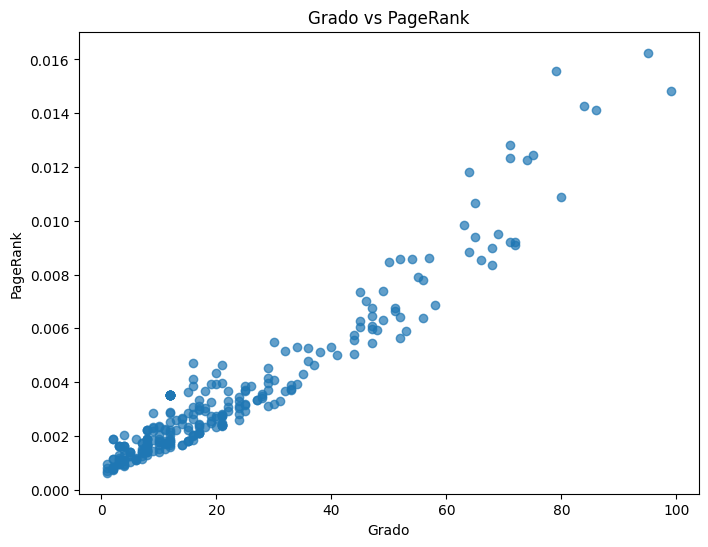

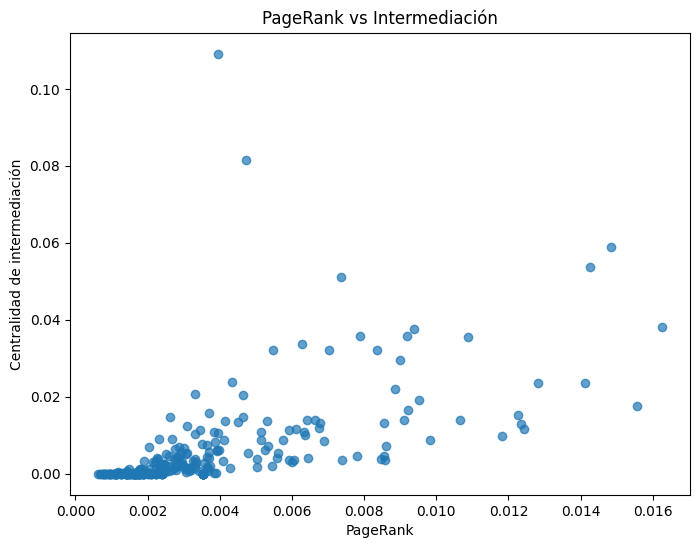

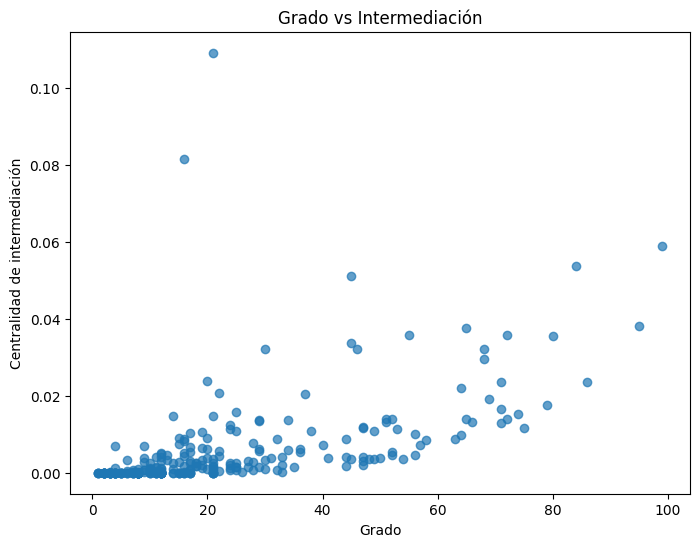

In [ ]:
intermediacion = nx.betweenness_centrality(G_gigante)
pagerank = nx.pagerank(G_gigante)
cercania = nx.closeness_centrality(G_gigante)

# Gráfico Dispersión de grado vs PageRank
grados_dict = dict(G_gigante.degree())
grados_lista = list(grados_dict.values())
pagerank_lista = [pagerank[n] for n in G_gigante.nodes()]

plt.figure(figsize=(8, 6))
plt.scatter(grados_lista, pagerank_lista, alpha=0.7)
plt.xlabel("Grado")
plt.ylabel("PageRank")
plt.title("Grado vs PageRank")
plt.show()


# Grafico PageRank vs Intermediación:
intermediacion_lista = [intermediacion[n] for n in G_gigante.nodes()]
plt.figure(figsize=(8,6))
plt.scatter(pagerank_lista, intermediacion_lista, alpha=0.7)
plt.xlabel("PageRank")
plt.ylabel("Centralidad de intermediación")
plt.title("PageRank vs Intermediación")


# Gráfico Dispersión de grado vs Intermediación:
plt.figure(figsize=(8,6))
plt.scatter(grados_lista, intermediacion_lista, alpha=0.7)
plt.xlabel("Grado")
plt.ylabel("Centralidad de intermediación")
plt.title("Grado vs Intermediación")
plt.show()

## Mayores desviaciones:

Viendo los gráficos de dispersión creados podemos notar que:
- En el gráfico **Grado vs PageRank** no existen mayores desviaciones significativas que se puedan destacar, por lo que todos los nodos se apegan al patrón general de este, no hay nodos de grado bajo con PageRank alto ni viceversa.
- En el gráfico **PageRank vs Intermediación** existen varias desviaciones respecto al patrón general, sobretodo de PageRank alto con baja centralidad de intermediación. En cuanto a **nodos con alta intermediación pero bajo PageRank**, estos están ubicados en caminos importantes dentro de la red pero no tienen conexiones directas suficientes con nodos centrales para aumentar PageRank.
- En el gráfico de **Grado vs Intermediación** podemos notar, de forma similar al anterior, varias desviaciones respecto al patrón, pero con un poco más de notoriedad y una leve mayor dispersión. En cuanto a los **nodos de alto grado con baja intermediación**, aunque estos nodos tienen muchas conexiones, no suelen estar en caminos críticos entre otros nodos, probablemente son nodos perifericos que se conectan densamente en sus propias comunidades pero sin conectar otros grupos.
** No se identificaron nodos con bajo grado, baja intermediación y bajo PageRank por lo que no se destacadan individuos fuera de las interacciones principales del grupo.

## Red coloreada según valores de distintas centralidades:

### Coloreado según PageRank:

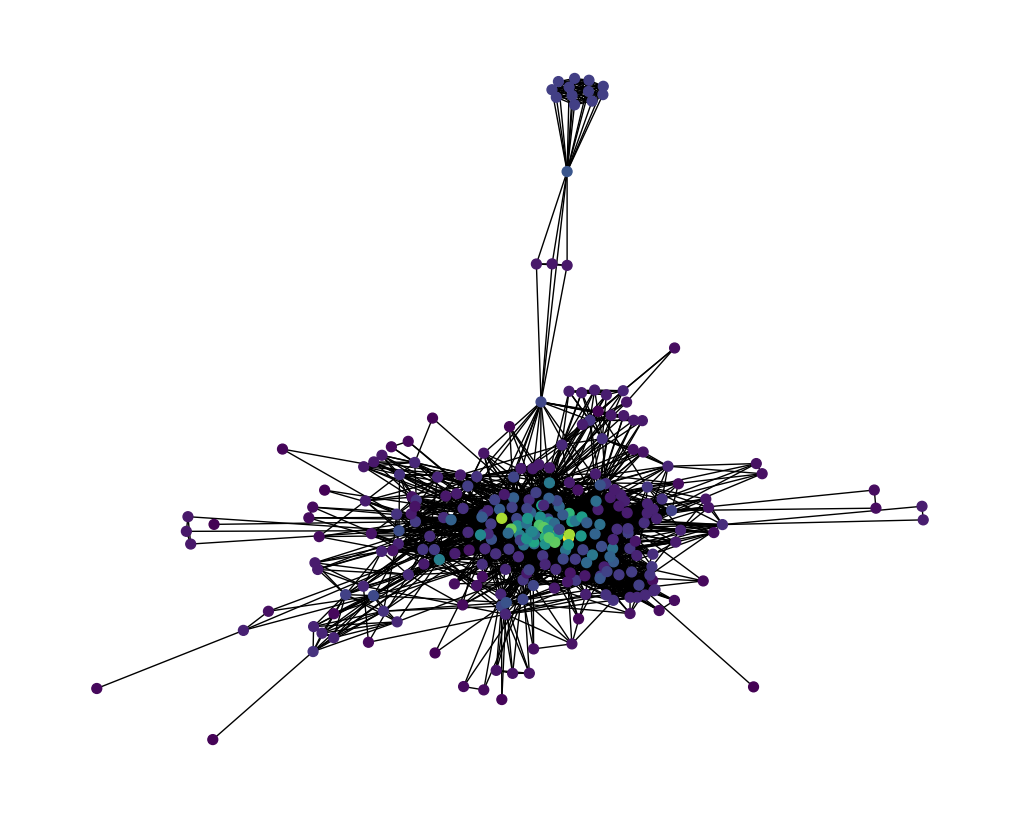

In [ ]:
values = [pagerank[n] for n in G_gigante.nodes()]
plt.figure(figsize=(10,8))
nx.draw_spring(G_gigante, node_color=values, cmap=cm.viridis, with_labels=False, node_size=50)
plt.show()

### Coloreado según intermediación:

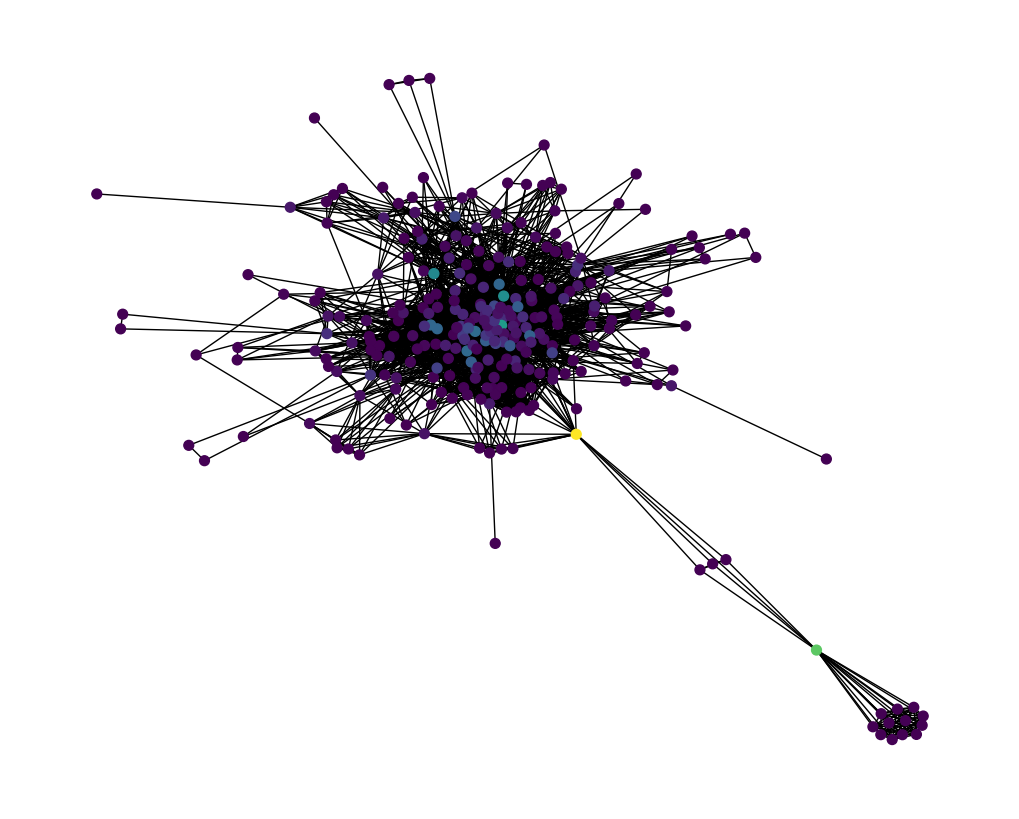

In [ ]:
values = [intermediacion[n] for n in G_gigante.nodes()]
plt.figure(figsize=(10,8))
nx.draw_spring(G_gigante, node_color=values, cmap=cm.viridis, with_labels=False, node_size=50)
plt.show()

### Coloreado según cercanía:

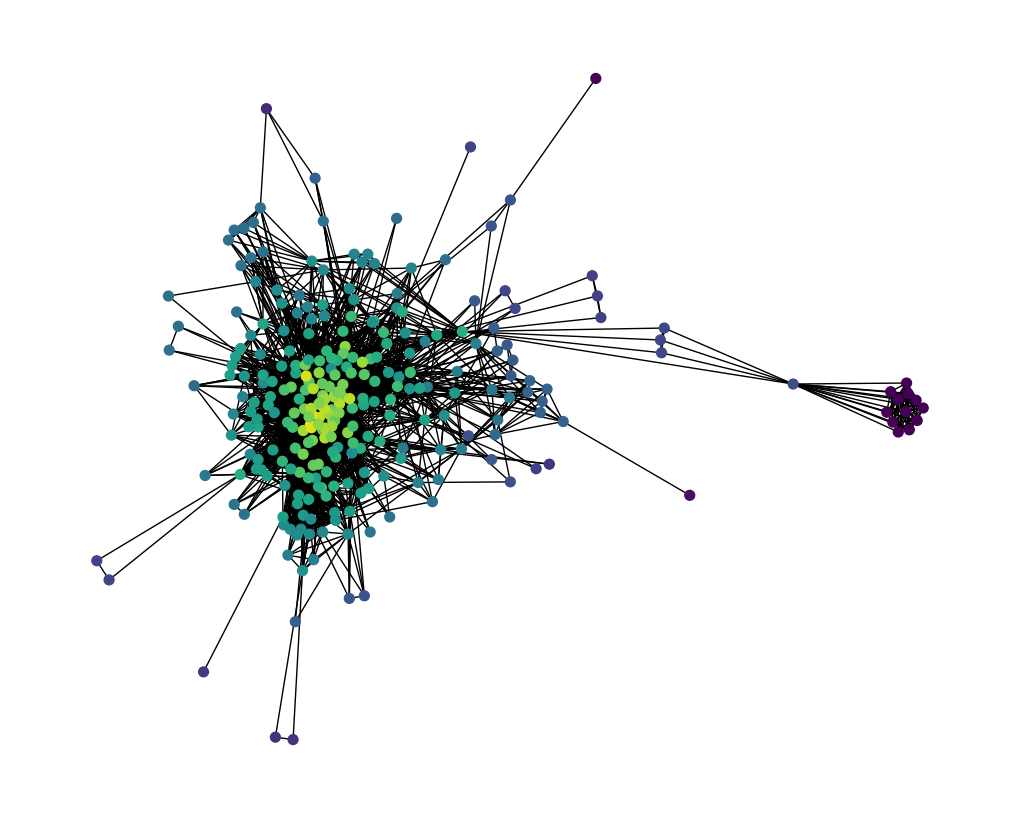

In [ ]:
values = [cercania[n] for n in G_gigante.nodes()]
plt.figure(figsize=(10,8))
nx.draw_spring(G_gigante, node_color=values, cmap=cm.viridis, with_labels=False, node_size=50)
plt.show()

# **Núcleos/Perifería**

In [ ]:
cant_cores = nx.core_number(G_gigante)
k_max = max(cant_cores.values())
print("Profundidad máxima (k-core): ", k_max)

k_shells = Counter(cant_cores.values())
print("Cantidad de nodos por k-shell:", dict(k_shells))


Profundidad máxima (k-core):  30
Cantidad de nodos por k-shell: {12: 18, 21: 23, 30: 31, 16: 7, 8: 46, 11: 19, 13: 6, 9: 5, 3: 13, 10: 9, 22: 12, 14: 8, 2: 10, 1: 4, 25: 6, 6: 6, 4: 11, 15: 9, 18: 5, 19: 6, 7: 7, 5: 6, 17: 15, 20: 2}


# **Comunidades**

El algoritmo de Louvain es no determinista, por lo que en cada ejecución se producen particiones diferentes e internamente se utilizan procesos aleatorios para optimizar la modularidad, es por ello que existen ligeras variaciones en el número de comunidades, su asignación de nodos y colores.

Cantidad de comunidades: 8
Tamaño de cada comunidad: {0: 41, 1: 16, 2: 40, 3: 66, 4: 21, 6: 39, 7: 8, 5: 53}
Modularidad obtenida: 0.3392721087384656


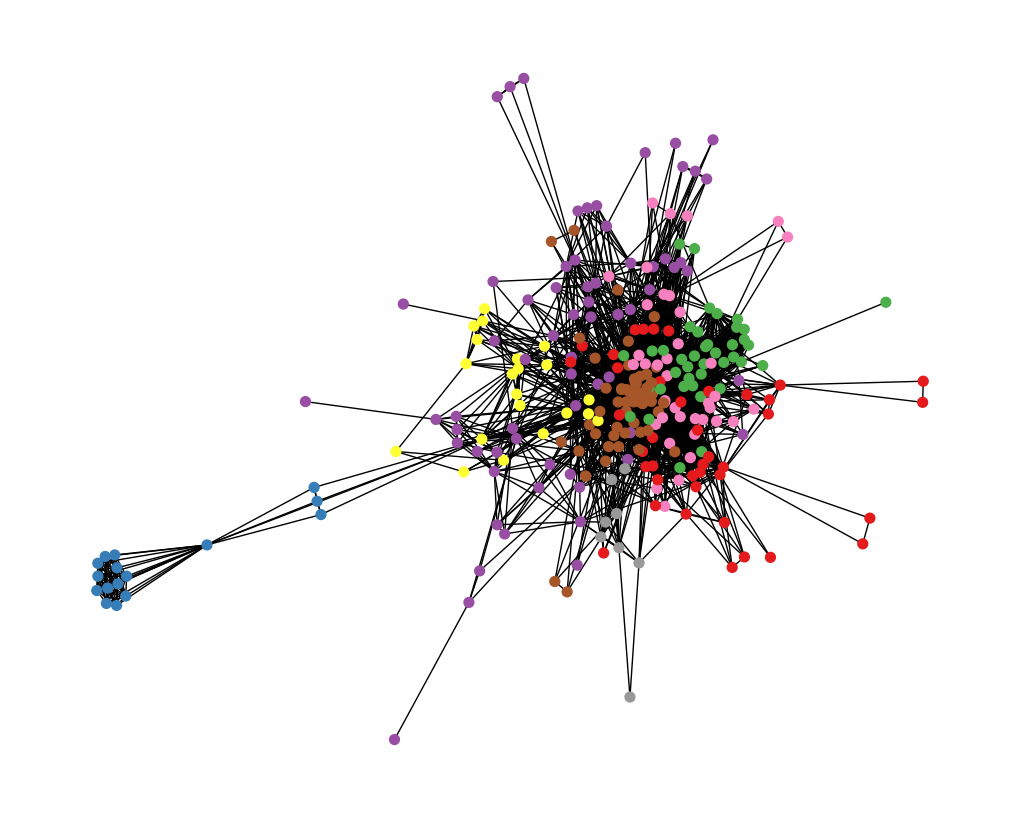

In [ ]:
# Partición y la modularidad:
particion = community_louvain.best_partition(G_gigante)
modularidad = community_louvain.modularity(particion, G_gigante)


# Tamaños de las comunidades:
tamanos_comunidades = Counter(particion.values())

print("Cantidad de comunidades:", len(set(particion.values())))
print("Tamaño de cada comunidad:", dict(tamanos_comunidades))
print("Modularidad obtenida:", modularidad)


# Visualizar la red coloreada por comunidad
values = [particion[n] for n in G_gigante.nodes()]
plt.figure(figsize=(10,8))
nx.draw_spring(G_gigante, node_color=values, cmap=cm.Set1, with_labels=False, node_size=50)
plt.show()


En la red se logra apreciar la estructura de comunidades a través de la cercanía y la coloración. Los colores muestran agrupaciones claras, sin embargo, no son muy aisladas, hay varias conexiones entre nodos de diferentes colores, por lo tanto existe una interacción activa entre las distintas comunidades.

# **Asortatividad**

In [ ]:
asortatividad = nx.degree_assortativity_coefficient(G_gigante)

print("Coeficiente de correlación de Newman:", asortatividad)


Coeficiente de correlación de Newman: 0.17119746730455046


El coeficiente presenta un valor **mayor a 0**, por lo tanto podemos concluir que **la red es asortativa**, es decir, sus nodos tienden a conectarse con otros que tengan un grado similar al suyo.

# **Modelo estructural**

In [3]:
grado_sec = [d for n, d in G_gigante.degree()]

resultados_aleat = []

for i in range(10):
    G_aleatorio = nx.configuration_model(grado_sec, seed=42+i)
    G_aleatorio = nx.Graph(G_aleatorio)
    G_aleatorio.remove_edges_from(nx.selfloop_edges(G_aleatorio))

    # Métricas requeridas:
    try:
        particion_aleatoria = community_louvain.best_partition(G_aleatorio)
        modularidad_aleatoria = community_louvain.modularity(particion_aleatoria, G_aleatorio)
    except Exception as e:
        modularidad_aleatoria = None

    try:
        asortatividad_aleatoria = nx.degree_assortativity_coefficient(G_aleatorio)
    except Exception as e:
        asortatividad_aleatoria = None

    try:
        cluster_promedio_aleatorio = nx.average_clustering(G_aleatorio)
    except Exception as e:
        cluster_promedio_aleatorio = None

    try:
        core_aleatorio = nx.core_number(G_aleatorio)
        k_max_aleatorio = max(core_aleatorio.values())
    except Exception as e:
        k_max_aleatorio = None

    resultados_aleat.append({
        'modularidad': modularidad_aleatoria,
        'asortatividad': asortatividad_aleatoria,
        'clustering_promedio': cluster_promedio_aleatorio,
        'max_k': k_max_aleatorio
    })

df_resultados = pd.DataFrame(resultados_aleat)
print(df_resultados.describe())

print("\n Métricas para la red original:")
print("Modularidad:", modularidad)
print("Asortatividad:", asortatividad)
print("Clustering promedio:", avg_clustering)
print("Profundidad k-core máxima:", max(cant_cores.values()))


NameError: name 'G_gigante' is not defined

Al analizar la red de interacciones sociales de delfines en Florida, se generaron 10 redes aleatorias que mantienen la misma distribución de grados que la red real para comparar algunas métricas clave:

- **Modularidad**: Las redes aleatorias tienen un valor promedio cercano a 0.16, mientras que la red real alcanza 0.35. Esto sugiere que la alta modularidad en la red de delfines no se debe únicamente a la distribución de grados, sino que hay una organización interna más definida, posiblemente relacionada con comunidades o grupos sociales específicos.

- **Asortatividad**: Mientras que las redes aleatorias muestran valores levemente negativos (alrededor de -0.047), la red real presenta un valor positivo de 0.17. Esto indica que, en la población de delfines, es más probable que individuos con un número similar de interacciones se conecten entre sí, algo que no se replica en las redes aleatorias.

- **Clustering**: El coeficiente de clustering promedio es de aproximadamente 0.19 en las redes aleatorias, pero en la red de delfines es mucho mayor (0.68). Esto evidencia una tendencia fuerte a la formación de grupos locales o "circuitos sociales" en la población real, lo que apunta a relaciones sociales más estrechas y densas.

- **Profundidad de k-core**: La máxima profundidad de k-core en las redes aleatorias es de alrededor de 16, en comparación con 30 en la red real. Esto demuestra que el núcleo central de la red de delfines es más robusto y denso, lo que podría reflejar la importancia de ciertos individuos en la cohesión del grupo.

En resumen, aunque las redes aleatorias comparten la misma distribución de grados que la red de delfines, las diferencias en modularidad, asortatividad, clustering y k-core indican que la estructura social real posee características específicas. Estos rasgos parecen surgir de factores adicionales propios de las interacciones sociales en la población de delfines, más allá de lo que se esperaría solo a partir de la distribución de grados.